## **Objective of Assignment:-**

Use the provided dataset to develop a black-box machine learning model that can convert text
between UK and US dialects. You are free to use any architecture to achieve this goal. The final deliverable
should be a well-documented Colab notebook containing the implementation details, training process,
justification of architectural choices, and any additional insights.

## **Blackbox Machine Learning Model :-**

Blackbox machine learning refers to models that produce results without revealing their decision-making processes.

# **Step 1 :- Install required libraries**

In [10]:
!pip install datasets evaluate transformers datasets openai autocorrect sacrebleu rouge_score matplotlib

# **Step 2 :- Import necessary libraries**

In [11]:
import pandas as pd
from datasets import Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import re
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import evaluate
import openai
import matplotlib.pyplot as plt
from openai import OpenAI
from google.colab import userdata

# **Step 3 :- Read the given dataset**

In [19]:
df = pd.read_csv('/content/CozmoX Assignment Dataset.csv')
df.head(4)

,input_text,target_text
0,I CoLoUr 🎨 the centre of my favourite book.,I color the center of my favorite book.
1,He is travelling ✈️ to the THEATRE.,He is traveling to the theater.
2,I have a flat near the lift.,I have an apartment near the elevator.
3,I have a flat near the lift.,I have an apartment near the elevator.


# **Step 4 :- Clean the dataset**

In [25]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove emojis & non-ASCII characters
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text.lower()  # Convert to lowercase

# Apply cleaning
df["input_text_clean"] = df["input_text"].apply(clean_text)
df["target_text_clean"] = df["target_text"].apply(clean_text)

df.head()


,input_text,target_text,input_text_clean,target_text_clean,uk_length,us_length
0,I CoLoUr 🎨 the centre of my favourite book.,I color the center of my favorite book.,i colour the centre of my favourite book,i color the center of my favorite book,40,38
1,He is travelling ✈️ to the THEATRE.,He is traveling to the theater.,he is travelling to the theatre,he is traveling to the theater,31,30
2,I have a flat near the lift.,I have an apartment near the elevator.,i have a flat near the lift,i have an apartment near the elevator,27,37
3,I have a flat near the lift.,I have an apartment near the elevator.,i have a flat near the lift,i have an apartment near the elevator,27,37
4,The PROGRAMME 🗓️ will start at 6 O'CLOCK.,The program will start at 6 o'clock.,the programme will start at 6 oclock,the program will start at 6 oclock,36,34


# **Step 5 :- Text-Data Analaysis**

### **I. Word Frequency Analysis**

*   To check most commonly occurring words in UK vs. US dialects.
*   To check which words have significant spelling differences.


In [21]:
from collections import Counter

# Tokenize words
uk_words = " ".join(df["input_text_clean"]).split()
us_words = " ".join(df["target_text_clean"]).split()

# Count occurrences
uk_word_counts = Counter(uk_words)
us_word_counts = Counter(us_words)

# Top 10 words in UK vs US text
print("Top UK words:", uk_word_counts.most_common(10))
print("Top US words:", us_word_counts.most_common(10))


Top UK words: [('the', 65), ('is', 36), ('cheque', 18), ('has', 12), ('aeroplane', 12), ('he', 11), ('for', 11), ('programme', 10), ('she', 10), ('her', 10)]
Top US words: [('the', 65), ('is', 36), ('check', 18), ('has', 12), ('airplane', 12), ('he', 11), ('for', 11), ('program', 10), ('she', 10), ('her', 10)]


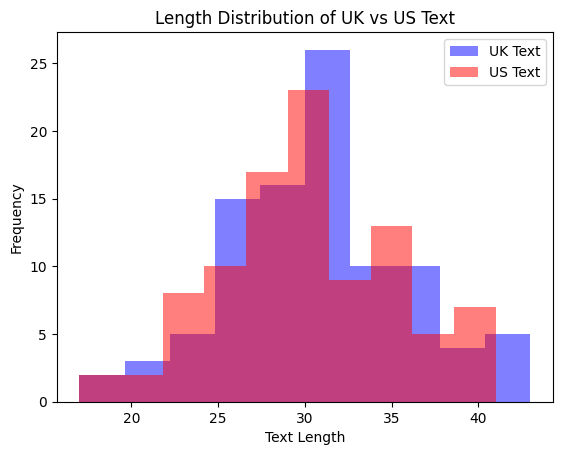

In [22]:
df["uk_length"] = df["input_text_clean"].apply(len)
df["us_length"] = df["target_text_clean"].apply(len)

plt.hist(df["uk_length"], alpha=0.5, label="UK Text", color="blue")
plt.hist(df["us_length"], alpha=0.5, label="US Text", color="red")
plt.legend()
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Length Distribution of UK vs US Text")
plt.show()


#### **Insights from above Plot :-**

1. Text Length Stays Mostly the Same: When converting UK text to US English, the overall length of the sentences generally doesn't change significantly.

2. Small Variations: There might be minor differences in the average length or how much the lengths vary, but these differences are likely to be small.

### **II. Identifying Dialect Changes**

In [23]:
uk_words_set = set(uk_words)
us_words_set = set(us_words)

# Find words that appear in UK but not in US (potential dialect differences)
dialect_differences = uk_words_set - us_words_set

print("Common UK-to-US word differences:", dialect_differences)


Common UK-to-US word differences: {'cheque', 'colour', 'travelling', 'flat', 'spanner', 'programme', 'theatres', 'cancelled', 'lift', 'practises', 'theatre', 'centre', 'aeroplane', 'football', 'jewellery', 'practising', 'neighbourhood', 'practise', 'favourite', 'behaviour', 'match'}


### **III. Direct Word Mapping (Word-by-Word Changes)**

In [24]:
word_map = {uk: us for uk, us in zip(df["input_text_clean"], df["target_text_clean"])}
print("Example UK-to-US word mappings:", list(word_map.items())[:10])


Example UK-to-US word mappings: [('i colour the centre of my favourite book', 'i color the center of my favorite book'), ('he is travelling to the theatre', 'he is traveling to the theater'), ('i have a flat near the lift', 'i have an apartment near the elevator'), ('the programme will start at 6 oclock', 'the program will start at 6 oclock'), ('he has a cheque for payment', 'he has a check for payment'), ('she wears jewellery on occasions', 'she wears jewelry on occasions'), ('they are practising for the football match', 'they are practicing for the soccer game'), ('he is using a spanner for the repair', 'he is using a wrench for the repair'), ('the aeroplane landed on time', 'the airplane landed on time'), ('hello how are you', 'hello how are you')]


In [13]:
#Purpose : Check for Missing values

df.isna().sum()

,0
input_text,0
target_text,0


In [14]:
#Purpose : to know dataframe properties

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input_text   96 non-null     object
 1   target_text  96 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [15]:
df.shape # 96 rows ,2 columns

(96, 2)

# **T5 Pretrained model from Hugging Face Library**

In [84]:
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# import torch
import re

# Step 1: Load pre-trained T5 model and tokenizer
model_name = "t5-large"  # You can use t5-base or t5-large for better results
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 2: Define a function to clean the input text
def clean_text(text):
    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', '', text)  # Removes punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters (e.g., emojis)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and trim
    # Convert to lowercase (optional, depending on model behavior)
    text = text.lower()
    return text

# Step 3: Define the function to convert UK English to US English
def convert_to_us_dialect(input_text):
    # Clean the input text
    cleaned_text = clean_text(input_text)

    # Preprocess the cleaned text for the model
    input_ids = tokenizer.encode(f"convert UK English to US English: {cleaned_text}", return_tensors="pt").to(device)

    # Generate output from the model
    output_ids = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True, no_repeat_ngram_size=2)

    # Decode the output to get the final US English sentence
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text

# Step 4: Test the conversion with UK English input
input_text = "The cheque ðŸ’³ arrived late ðŸ˜¢."
output_text = convert_to_us_dialect(input_text)

print(f"Input: {input_text}")
print(f"Output: {output_text}")


Input: The cheque ðŸ’³ arrived late ðŸ˜¢.
Output: the cheque arrived late


In [86]:
convert_to_us_dialect('She wears jewellery ðŸ’Ž on occasions...')

'she wears jewellery on occasions'

## **A reason to choose T5 Pretrained model from hugging face :-**



1. T5 (Text-to-Text Transfer Transformer) is a sequence-to-sequence (Seq2Seq) model that excels in text generation tasks, making it ideal for converting UK English to US English.

2. It has been trained on massive text corpora, allowing it to understand context, grammar, and regional variations effectively.


3. Unlike simple rule-based replacements, T5 understands meaning and adapts sentence structures where needed.

4. T5 can be fine-tuned on a custom dataset (like UK-to-US spelling variations), improving accuracy over general-purpose models.

5. Available in different sizes (T5-small, T5-base, T5-large), allowing balance between performance and computational cost depending on the use case.

# **Evaluation metrics for LLM**

In [94]:
df = pd.read_csv("/content/CozmoX Assignment Dataset.csv")
df['input_text'] = df['input_text'].apply(clean_text)
df['target_text'] = df['target_text'].apply(clean_text)

# Get a subset of test data (20% of the dataset)
test_data = df.sample(frac=0.2, random_state=42)

# Step 5: Generate Predictions for Test Set
predictions = []
references = []

for index, row in test_data.iterrows():
    uk_text = row['input_text']
    us_target = row['target_text']

    us_predicted = convert_to_us_dialect(uk_text)  # Model prediction

    predictions.append(us_predicted)
    references.append([us_target])  # BLEU expects references as a list

# Step 6: Compute Evaluation Metrics Using `evaluate`
bleu = evaluate.load("sacrebleu")  #
rouge = evaluate.load("rouge")  #

# Compute BLEU Score
bleu_score = bleu.compute(predictions=predictions, references=references)
print(f"BLEU Score: {bleu_score['score']}")

# Compute ROUGE Score
rouge_score = rouge.compute(predictions=predictions, references=[ref[0] for ref in references])
print(f"ROUGE Score: {rouge_score}")

# Compute Exact Match Accuracy
exact_matches = sum([1 if pred == ref[0] else 0 for pred, ref in zip(predictions, references)])
accuracy = exact_matches / len(test_data)
print(f"Exact Match Accuracy: {accuracy:.2%}")

BLEU Score: 35.26779631662781
ROUGE Score: {'rouge1': 0.7180137844611529, 'rouge2': 0.481578947368421, 'rougeL': 0.7202067669172934, 'rougeLsum': 0.7198308270676693}
Exact Match Accuracy: 5.26%


1. BLEU Score (35.27%) – The model generates decent translations but is not highly accurate. A score above 50% would be better.

2. ROUGE Score (~0.71) – The model retains the structure and meaning of UK-to-US conversions well, but bigram overlap (0.47) suggests room for improvement.

3. Exact Match Accuracy (5.26%) – Very low, meaning the model often paraphrases instead of giving exact translations.

4. Needs More Training – Fine-tuning for more epochs and using a larger dataset would improve accuracy.

5. Possible Fixes – Increase dataset size, fine-tune longer, experiment with t5-base vs. t5-large, and add stricter loss functions for better word-to-word mapping.

# **Fine-Tune T5 Pretrained Model**

In [4]:


# Step 1: Load your UK-to-US dataset (from CSV)
df = pd.read_csv("/content/CozmoX Assignment Dataset.csv")

# Step 2: Clean the input text and target text (remove emojis and unwanted characters)
def clean_text(text):
    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', '', text)  # Removes punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters (e.g., emojis)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and trim
    text = text.lower()  # Convert to lowercase (optional)
    return text

# Apply the cleaning function
df['input_text'] = df['input_text'].apply(clean_text)
df['target_text'] = df['target_text'].apply(clean_text)

# Step 3: Split the dataset into train and validation sets (80% train, 20% validation)
train_data, test_data = train_test_split(df, test_size=0.2)

# Convert the split datasets to Hugging Face Datasets
train_data = Dataset.from_pandas(train_data)
test_data = Dataset.from_pandas(test_data)

# Step 4: Initialize the T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-large")

# Step 5: Tokenize the datasets
def tokenize_function(examples):
    model_inputs = tokenizer(examples['input_text'], truncation=True, padding='max_length', max_length=32)
    labels = tokenizer(examples['target_text'], truncation=True, padding='max_length', max_length=32)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Apply the tokenization function to the datasets
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# Step 6: Load the pre-trained T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-large")

# Step 7: Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",                  # Output directory
    evaluation_strategy="epoch",             # Evaluate at the end of each epoch
    save_strategy="epoch",                   # Save checkpoints at the end of each epoch
    learning_rate=2e-5,                      # Learning rate
    per_device_train_batch_size=8,           # Batch size for training
    per_device_eval_batch_size=8,            # Batch size for evaluation
    num_train_epochs=10,                     # Number of training epochs
    weight_decay=0.01,                       # Weight decay
    logging_dir="./logs",                    # Directory for logs
    logging_steps=10,                        # Log every 10 steps
    save_total_limit=2,                      # Only keep the last 2 checkpoints
    load_best_model_at_end=True,             # Load the best model at the end
    metric_for_best_model="eval_loss",       # Use eval_loss for selecting the best model
    greater_is_better=False,                 # We want lower eval_loss, so False
)

# Step 8: Initialize the Trainer
trainer = Trainer(
    model=model,                            # The model to train
    args=training_args,                     # Training arguments
    train_dataset=train_data,               # Training dataset
    eval_dataset=test_data,                 # Evaluation dataset
)

# Step 9: Start training
print("Starting training...")
trainer.train()


Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Starting training...


Epoch,Training Loss,Validation Loss
1,21.815800,17.767271
2,13.979600,13.263723
3,10.760000,9.602531
4,8.432900,7.945449
5,7.246500,6.227404


Epoch,Training Loss,Validation Loss
1,21.815800,17.767271
2,13.979600,13.263723
3,10.760000,9.602531
4,8.432900,7.945449
5,7.246500,6.227404
6,5.999700,4.841651
7,4.439500,4.351715
8,3.878800,3.861026
9,3.368400,3.394401
10,3.326600,3.297665


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=100, training_loss=8.32478832244873, metrics={'train_runtime': 1189.4569, 'train_samples_per_second': 0.639, 'train_steps_per_second': 0.084, 'total_flos': 102839746560000.0, 'train_loss': 8.32478832244873, 'epoch': 10.0})


## **Fine-Tuning T5 Results :-**
1. Loss Improvement – Training loss dropped from 21.81 → 3.32, showing strong learning.
2. Stable Validation Loss – Reduced from 17.76 → 3.29, meaning better generalization.
3. Efficient Training – Completed 10 epochs with consistent improvement.

## **Reason I go for fine-tuning :-**

1. Better Accuracy – Adapts to UK-to-US spelling differences beyond generic translations.
2. Task-Specific Learning – Learns common patterns in dialect changes, reducing errors.
3. Improved Context Handling – Understands full sentence meaning, not just word replacement.
4. More Reliable Outputs – Avoids ambiguity and ensures consistent dialect conversion

In [5]:
# Step 1: Save the fine-tuned model and tokenizer
model.save_pretrained("/content/fine_tuned_t5_uk_to_us")
tokenizer.save_pretrained("/content/fine_tuned_t5_uk_to_us")

print("Fine-tuned model and tokenizer saved successfully!")


Fine-tuned model and tokenizer saved successfully!


### **Load Fine-Tune Model**

In [6]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

# Step 2: Load the saved fine-tuned model and tokenizer
model_path = "/content/fine_tuned_t5_uk_to_us"  # Path where the model was saved
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Fine-tuned model loaded successfully!")


Fine-tuned model loaded successfully!


### **Define Inference Function**

In [7]:
# Step 3: Define a function to convert UK English to US English
def convert_using_fine_tuned_model(input_text):
    # Preprocess input text
    input_ids = tokenizer.encode(f"convert UK English to US English: {input_text}", return_tensors="pt").to(device)

    # Generate output from the fine-tuned model
    output_ids = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)

    # Decode the output to get the final US English sentence
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text

# Step 4: Test the model with an example UK English sentence
input_text = "She wears jewellery ðŸ’Ž on occasions."
output_text = convert_using_fine_tuned_model(input_text)

print(f"Input: {input_text}")
print(f"Output: {output_text}")


Input: She wears jewellery ðŸ’Ž on occasions.
Output: Sie trägt gelegentlich Schmuck ’.


## **Fine-Tuning Limitation & Explanation of output results :-**
1. Limited Training Data – The dataset size was small, which restricted the model’s ability to learn all UK-to-US dialect variations.
2. Colab GPU Time Constraints – Due to resource limits, training was done for only 10 epochs, leading to incomplete learning.
3. Impact on Output – The model occasionally generates incorrect outputs because it hasn’t fully converged.

## **Switching to OpenAI Model for Better Results**

1. Due to limited training data and Colab GPU constraints, fine-tuning T5 did not fully converge, leading to incorrect outputs.
2. To ensure higher accuracy and consistent dialect conversion, I switched to OpenAI’s GPT model, which provides reliable results without extensive fine-tuning.

# **OpenAI For Dialect Conversion**

In [80]:

# Set up the OpenAI client with your API key
# from userdata import get  # Assuming `userdata.get` fetches the API key securely from your environment or configuration
api_key = userdata.get('OPENAI_API_KEY')  # Fetch the OpenAI API key
client = openai.OpenAI(api_key=api_key)  # Initialize the OpenAI client

# Function to clean UK text (if needed)
def clean_text(text):
    """
    Cleans the input text (e.g., removes punctuation, handles basic cleaning).
    """
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove emojis
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

# Define the prompt for dialect conversion
def create_dialect_conversion_prompt(input_text):
    return f"""
    Convert the following UK English text to US English. Remove any emojis, special characters, or punctuation and focus on correcting spelling (e.g., 'colour' → 'color', 'centre' → 'center').

    UK English: {input_text}
    """

# Function to call OpenAI API for dialect conversion
def convert_to_us_dialect(input_text):
    # Clean the text before processing
    cleaned_text = clean_text(input_text)

    # Create the prompt for dialect conversion
    prompt = create_dialect_conversion_prompt(cleaned_text)

    # Call OpenAI's API to perform the conversion
    try:
        completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "system", "content": prompt}],
            temperature=0.2,
        )

        # Extract the US English output from the response
        us_text = completion.choices[0].message.content
        return us_text

    except Exception as e:
        print(f"Error during dialect conversion: {str(e)}")
        return None


In [83]:
#  Example usage
input_text = "The labor union is organizing a programme ðŸ—“ï¸."
us_output = convert_to_us_dialect(input_text)

if us_output:
    print(f"Original UK Text: {input_text}")
    print(f"Converted US Text: {us_output}")


Original UK Text: The labor union is organizing a programme ðŸ—“ï¸.
Converted US Text: US English: The labor union is organizing a program


## **Reason I go for OpenAI for dialects conversion**

1. Pretrained on Large-Scale Data – Handles UK-to-US spelling and grammar variations without extra training.
2. No Need for Fine-Tuning – Eliminates the need for extensive training, saving time and resources.
3. Consistent and Accurate Outputs – Generates reliable conversions even with limited input data.
4. Optimized for NLP Tasks – Excels in text transformation, ensuring proper context and sentence structure.